In [1]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from data_generator_boneage import BoneAgeDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency
from utils import nll_criterion_gaussian

matplotlib.rcParams['font.size'] = 8

In [2]:
base_model = 'resnet101'

In [3]:
assert base_model in ['resnet50', 'resnet101', 'densenet121', 'densenet201', 'efficientnetb0', 'efficientnetb4']
device = torch.device("cuda:1")
resize_to = (256, 256)

In [4]:
batch_size = 16

data_set = BoneAgeDataset(data_dir='/media/fastdata/laves/rsna-bone-age/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./boneage_valid_indices.pth')
test_indices = torch.load('./boneage_test_indices.pth')
#calib_indices = test_indices[:len(test_indices)//2]
#test_indices = test_indices[len(test_indices)//2:]

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([2000])
torch.Size([4000])


In [5]:
model = BreastPathQModel(base_model, in_channels=1, out_channels=1).to(device)
checkpoint = torch.load(f"/media/fastdata/laves/regression_snapshots/{base_model}_laplacian_boneage_499.pth.tar", map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']))

# model._dropout_T = 1

Loading previous weights at epoch 499


In [6]:
model.eval()
mus_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_calib.append(mu.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach())

mu_calib = torch.cat(mus_calib, dim=0)
var_calib = torch.cat(vars_calib, dim=0)
logvar_calib = torch.cat(logvars_calib, dim=0)
target_calib = torch.cat(targets_calib, dim=0)

print("l1 =", torch.nn.functional.l1_loss(mu_calib, target_calib).item())

100%|██████████| 125/125 [03:26<00:00,  1.66s/it]

l1 = 0.04412022978067398


In [7]:
err_calib = torch.pow(target_calib-mu_calib, 2).sqrt()

uncertainty = 'total'

uncert_calib_aleatoric = logvar_calib.exp()
uncert_calib_epistemic = var_calib.sqrt()

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).clamp(0, 1)  # total

In [8]:
print(err_calib.mean())
print(uncert_calib.mean())
print(uncert_calib_aleatoric.mean())
print(uncert_calib_epistemic.mean())

tensor(0.0441, device='cuda:1')
tensor(0.0274, device='cuda:1')
tensor(0.0185, device='cuda:1')
tensor(0.0089, device='cuda:1')


<IPython.core.display.Javascript object>


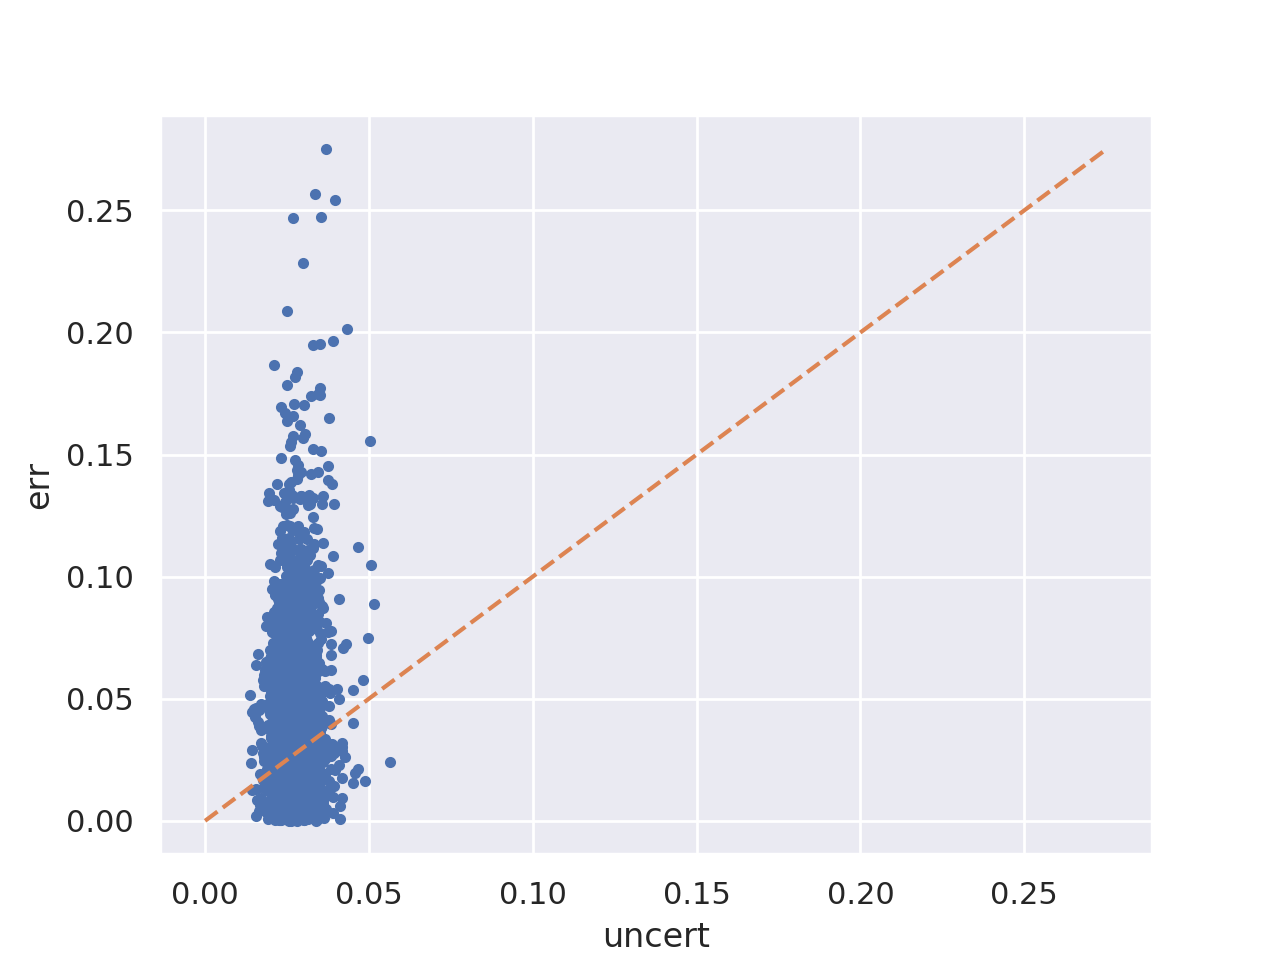

In [9]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu(), err_calib.cpu()[:,0], '.')

max_val = max(err_calib.max().item(), uncert_calib.max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.show()

In [10]:
# calculate optimal T
S = err_calib.sum() / uncert_calib.sum()
print(S)

tensor(1.6094, device='cuda:1')


In [11]:
class Scaler(torch.nn.Module):
    def __init__(self, init_S=1.0):
        super().__init__()
        self.S = torch.nn.Parameter(torch.tensor([init_S]))
        
    def forward(self, x):
        return self.S.mul(x)

In [12]:
# find optimal S
scaler = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler.S], lr=3e-4, max_iter=100)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler.S.item())

1.6180026531219482


In [13]:
print(nll_criterion_gaussian(mu_calib, uncert_calib.pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, (S*uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib).item())

-2.721850633621216
-4.53350305557251
-4.541282653808594


In [14]:
print(torch.nn.functional.l1_loss(uncert_calib, err_calib, reduction='sum').item())
print(torch.nn.functional.l1_loss((S*uncert_calib), err_calib, reduction='sum').item())
print(torch.nn.functional.l1_loss(scaler(uncert_calib), err_calib, reduction='sum').item())

56.760047912597656
57.032379150390625
57.12619400024414


<IPython.core.display.Javascript object>


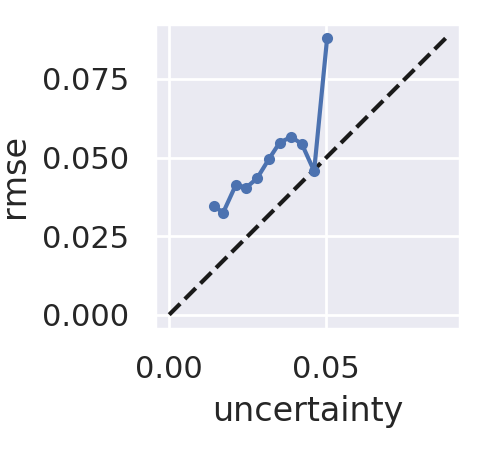

0.016725050285458565


In [15]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib, uncert_calib, outlier=0.002)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())
plt.show()

<IPython.core.display.Javascript object>


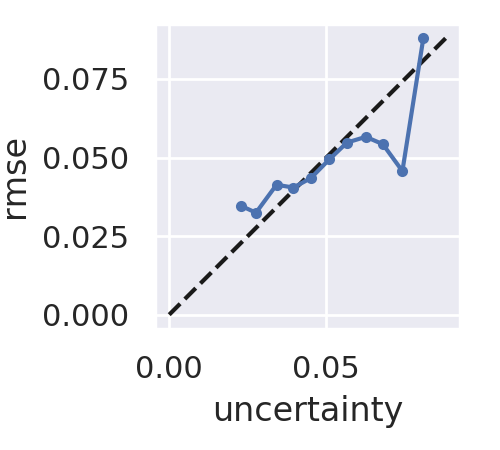

0.002304940251633525


In [16]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib, (S*uncert_calib), outlier=0.002)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())
plt.show()

<IPython.core.display.Javascript object>


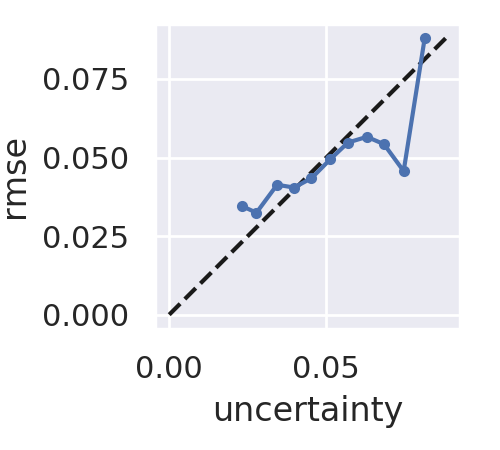

0.0023631600197404623


<IPython.core.display.Javascript object>


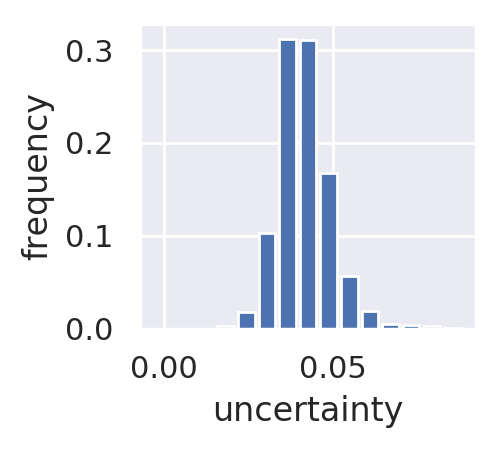

In [17]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib, scaler(uncert_calib), outlier=0.002)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item())
fig, ax = plot_frequency(scaler(uncert_calib).cpu(), freq_in_bin.cpu())
fig.show()

In [18]:
model.eval()
mus_test = []
vars_test = []
logvars_test = []
targets_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_test.append(mu.detach())
        vars_test.append(var_bayesian.detach())
        logvars_test.append(logvar.detach())
        targets_test.append(target.detach())

mu_test = torch.cat(mus_test, dim=0).clamp(0, 1)
var_test = torch.cat(vars_test, dim=0)
logvar_test = torch.cat(logvars_test, dim=0)
target_test = torch.cat(targets_test, dim=0)

print("l1 =", torch.nn.functional.l1_loss(mu_test, target_test).item())

100%|██████████| 250/250 [06:55<00:00,  1.65s/it]

l1 = 0.04571681097149849


In [19]:
err_test = torch.pow(target_test-mu_test, 2).sqrt()

uncert_aleatoric_test = logvar_test.exp()
uncert_epistemic_test = var_test.sqrt()

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.clamp(0, 1)
else:
    uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).clamp(0, 1)  # total

In [20]:
print(nll_criterion_gaussian(mu_test, uncert_test.log(), target_test).item())
print(nll_criterion_gaussian(mu_test, S*uncert_test.log(), target_test).item())
print(nll_criterion_gaussian(mu_test, scaler(uncert_test).log(), target_test).item())

-3.4793617725372314
-4.673412322998047
-3.0461127758026123


In [21]:
print(torch.nn.functional.l1_loss(uncert_test, err_test, reduction='sum').item())
print(torch.nn.functional.l1_loss((S*uncert_test), err_test, reduction='sum').item())
print(torch.nn.functional.l1_loss((scaler.S*uncert_test), err_test, reduction='sum').item())

115.43824005126953
114.27996063232422
114.44424438476562


<IPython.core.display.Javascript object>


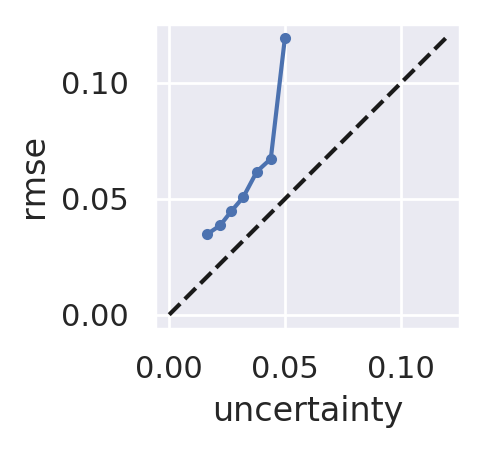

0.018096398562192917


In [22]:
uce, err_in_bin, avg_sigma_in_bin, _ = uceloss(err_test, uncert_test, outlier=0.001)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())

<IPython.core.display.Javascript object>


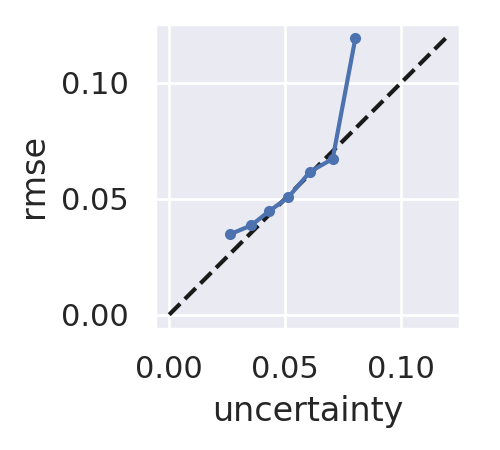

0.0017409451538696885


In [23]:
uce, err_in_bin, avg_sigma_in_bin, _ = uceloss(err_test, S*uncert_test, outlier=0.001)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())

<IPython.core.display.Javascript object>


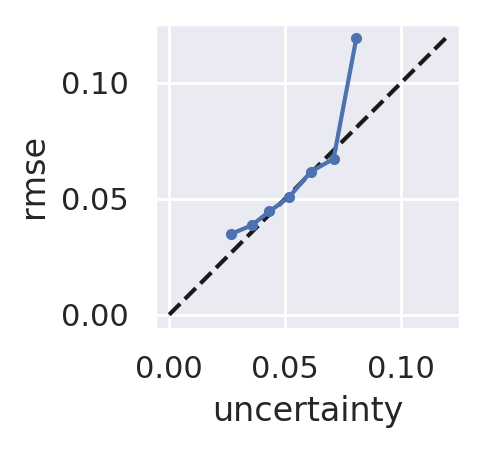

0.001640491303987801


<IPython.core.display.Javascript object>


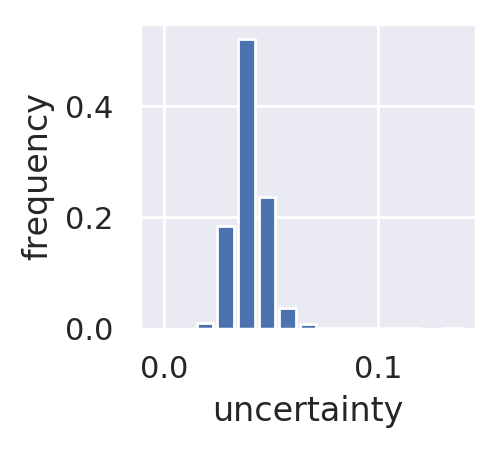

In [24]:
uce, err_in_bin, avg_sigma_in_bin, in_bin = uceloss(err_test, scaler(uncert_test), outlier=0.001)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
plt.show()
print(uce.item())
fig, ax = plot_frequency(scaler(uncert_test).cpu(), in_bin.cpu())
fig.show()